<a href="https://colab.research.google.com/github/rahiakela/practical-natural-language-processing/blob/chapter-4-text-classification/1_statistical_text_classification_with_naive_bayes_logistic_regression_and_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Text Classification with Naive Bayes, Logistic Regression and SVM

This notebook aims to give you a brief overview of performing text classification using Naive Bayes, Logistic Regression and Support Vector Machines based on statistical techniques. 

We will be using a dataset called "Economic news article tone and relevance" from [Figure-Eight](https://github.com/practical-nlp/practical-nlp/blob/master/Ch4/Data/Full-Economic-News-DFE-839861.csv) which consists of approximately 8000 news articles, which were tagged as relevant or not relevant to the US Economy. 

The dataset is also imbalanced, with `~1,500` relevant and `~6,500` non-relevant articles, which poses the challenge of guarding against
learning a bias toward the majority category (in this case, non-relevant articles). 

Clearly, learning what a relevant news article is is more challenging with this dataset than learning what is irrelevant. After all, just guessing that everything is irrelevant already gives us 80% accuracy!

Our goal in this notebook is to explore the process of training and testing text classifiers for this problem, using this data set and two text classification algorithms: Multinomial Naive Bayes and Logistic Regression, implemented in sklearn.

No single approach is known to work universally well on all kinds of data and all classification problems. In the real world, we experiment with multiple approaches, evaluate them, and choose one final approach to deploy in practice.



## Setup

In [1]:
import numpy as np
import pandas as pd #to work with csv files

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

#import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

#pre-processing of text
import string
import re
import itertools

#import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

#import time function from time module to track the training duration
from time import time

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


### Load and explore the dataset

In [2]:
!wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
!ls -lah DATAPATH

--2020-09-25 09:30:54--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [text/plain]
Saving to: ‘DATAPATH/Full-Economic-News-DFE-839861.csv’

Full-Economic-News- 100%[===================>]  11.81M  25.2MB/s    in 0.5s    

2020-09-25 09:30:55 (25.2 MB/s) - ‘DATAPATH/Full-Economic-News-DFE-839861.csv’ saved [12383529/12383529]

total 12M
drwxr-xr-x 2 root root 4.0K Sep 25 09:30 .
drwxr-xr-x 1 root root 4.0K Sep 25 09:30 ..
-rw-r--r-- 1 root root  12M Sep 25 09:30 Full-Economic-News-DFE-839861.csv


In [3]:
our_data = pd.read_csv("DATAPATH/Full-Economic-News-DFE-839861.csv", encoding="ISO-8859-1")

# Number of rows (instances) and columns in the dataset
display(our_data.shape)
# Class distribution in the dataset
our_data['relevance'].value_counts() / our_data.shape[0]

(8000, 15)

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

There is an imbalance in the data with not relevant being 82% in the dataset. That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics. We should keep this class imbalance mind when interpreting the classifier performance later. 

Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes (relevant), and 0 for No (not relevant), and ignore "Not sure".

In [4]:
# convert label to a numerical variable
our_data = our_data[our_data.relevance != "not sure"]
print(our_data.shape)

# relevant is 1, not-relevant is 0. 
our_data['relevance'] = our_data.relevance.map({"yes": 1, "no": 0})
# Let us take only the two columns we need.
our_data = our_data[["text", "relevance"]]
print(our_data.shape)

(7991, 15)
(7991, 2)


### Text Pre-processing

Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization. Other processes such as stemming/lemmatization can also be performed. 

Here, we are performing the following steps: removing br tags, punctuation, numbers, and stopwords. While we are using sklearn's list of stopwords, there are several other stop word lists (e.g., from NLTK) or sometimes, custom stopword lists are needed depending on the task.

In [5]:
stopwords = stop_words.ENGLISH_STOP_WORDS

def clean(doc):
  doc = doc.replace("</br>", " ")   # This text contains a lot of <br/> tags.
  # remove punctuation and numbers
  doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
  doc = " ".join([token for token in doc.split() if token not in stopwords])

  return doc

## Naive Bayes Classifier

Naive Bayes is a probabilistic classifier that uses Bayes’ theorem to classify texts based on the evidence seen in training data. It estimates the conditional probability of each feature of a given text for each class based on the occurrence of that feature in that class and multiplies the probabilities of all the features of a given text to compute the final probability of classification for each class. 

Finally, it chooses the class with maximum probability. 

Although simple, Naive Bayes is commonly used as a baseline algorithm
in classification experiments.

Once the dataset is loaded, we split the data into train and test data.

In [6]:
# Step 1: train-test split
X = our_data.text       # the column text contains textual data to extract features from
y = our_data.relevance  # this is the column we are learning to predict.
print(X.shape, y.shape)

# split X and y into training and testing sets. By default, it splits 75% training and 25% test random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


The next step is to pre-process the texts and then convert them into feature vectors. While there are many different ways to do the pre-processing.

Let’s say we want to do the following: lowercasing and removal of punctuation, digits and any custom strings, and stop words.

In [7]:
# Step 2-3: Pre-process and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean)        # instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)         # use it to extract features from training data

# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)

# the dimension of our feature vector is 49753!
print(X_train_dtm.shape, X_test_dtm.shape)

(5993, 49753) (1998, 49753)


We’ll see that we ended up having a feature vector with over 45,000 features! We now have the data in a format we want: **feature vectors**.

So, the next step is to train and evaluate a Naive Bayes classifier with the features we extracted above.

In [8]:
# Step 3: Train the classifier and predict for test data
nb = MultinomialNB()     # instantiate a Multinomial Naive Bayes model

# train the model(timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

CPU times: user 9.92 ms, sys: 3 ms, total: 12.9 ms
Wall time: 13.7 ms


In [9]:
# Step 4: Evaluate the classifier using various measures

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label',fontsize=15)
  plt.xlabel('Predicted label',fontsize=15)

In [10]:
# Print accuracy:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

Accuracy:  0.7822822822822822


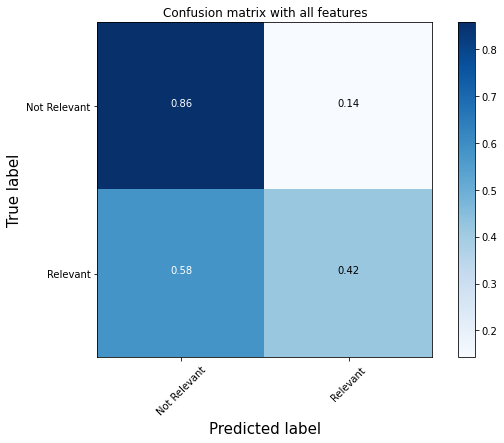

In [11]:
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'], normalize=True, title="Confusion matrix with all features")

The classifier is doing fairly well with identifying the nonrelevant
articles correctly, only making errors 14% of the time. However, it does not perform well in comparison to the second category: relevance. The category is identified correctly only 42% of the time.

In [12]:
# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", metrics.roc_auc_score(y_test, y_pred_prob))

ROC_AOC_Score:  0.7251117679464362


An obvious thought may be to collect more data. This is correct and often the most rewarding approach. But in the interest of covering other approaches, we assume that we cannot change it or collect additional data. This is not a far-fetched assumption—in industry, we often don’t have the luxury of collecting more data; we have to work with what we have.

At this point, we can notice that the classifier is doing poorly with identifying relevant articles, while it is doing well with non-relevant ones. Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning.

Let’s see how to improve our classification performance by addressing some of the possible reasons for it. One approach is to reduce noise in the feature vectors.

**A large number of features introduce sparsity; i.e., most of the features in the feature vector are zero, and only a few values are non-zero. This, in turn, affects the ability of the text classification algorithm to learn.**

Let’s see what happens if we restrict this to 5,000 and rerun the training and evaluation process. This requires us to change the CountVectorizer instantiation in the process.

CPU times: user 5.31 ms, sys: 0 ns, total: 5.31 ms
Wall time: 5.32 ms
Accuracy:  0.6876876876876877


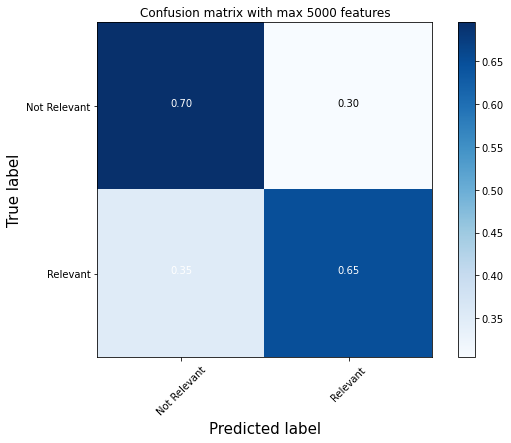

In [13]:
vect = CountVectorizer(preprocessor=clean, max_features=5000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()
# train the model(timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# Print accuracy
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'], normalize=True, title="Confusion matrix with max 5000 features")

Now, clearly, while the average performance seems lower than before, the correct identification of relevant articles increased by over 20%. 

At that point, one may wonder whether this is what we want. The answer to that question depends on the problem we’re trying to solve. 

If we care about doing reasonably well with non-relevant article identification and doing as well as possible with relevant article identification, or doing equally well with both, we could conclude that reducing the feature vector size with the Naive Bayes classifier was useful for this dataset.

## Logistic Regression

When we described the Naive Bayes classifier, we mentioned that it learns the probability of a text for each class and chooses the one with maximum probability. Such a classifier is called a generative classifier. 

In contrast, there’s a discriminative classifier that aims to learn the probability distribution over all classes. Logistic regression is an
example of a discriminative classifier and is commonly used in text classification, as a baseline in research, and as an MVP in real-world industry scenarios.

Unlike Naive Bayes, which estimates probabilities based on feature occurrence in classes, logistic regression “learns” the weights for individual features based on how important they are to make a classification decision. The goal of logistic regression is to learn a linear separator between classes in the training data with the aim of maximizing the probability of the data. This “learning” of feature weights and probability distribution over all classes is done through a function called “logistic” function.

Let’s take the 5,000-dimensional feature vector from the last step of the Naive Bayes example and train a logistic regression classifier instead of Naive Bayes.

In [14]:
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy:  0.7362362362362362
AUC:  0.7251117679464362


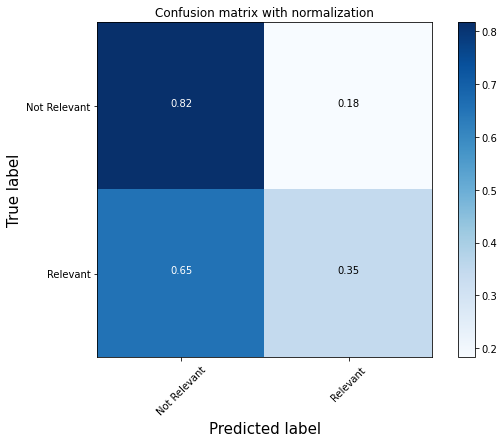

In [18]:
# instantiate a logistic regression model
logreg = LogisticRegression(class_weight="balanced")
# fit the model with training data
logreg.fit(X_train_dtm, y_train)

# Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

# calculate evaluation measures
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("AUC: ", metrics.roc_auc_score(y_test, y_pred_prob))

cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'], normalize=True, title="Confusion matrix with normalization")

Our logistic regression classifier instantiation has an argument class_weight, which is given a value “balanced”. This tells the classifier to boost the weights for classes in inverse proportion to the number of samples for that class. So, we expect to see better performance for the less-represented classes.

We can experiment with this code by removing that argument and retraining the classifier, to witness a fall (by approximately 5%) in the bottom-right cell of the confusion matrix. 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy:  0.7682682682682682
AUC:  0.7251117679464362


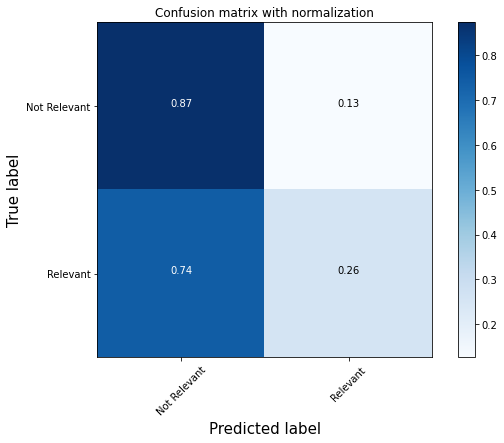

In [19]:
# instantiate a logistic regression model
logreg = LogisticRegression()
# fit the model with training data
logreg.fit(X_train_dtm, y_train)

# Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

# calculate evaluation measures
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("AUC: ", metrics.roc_auc_score(y_test, y_pred_prob))

cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'], normalize=True, title="Confusion matrix with normalization")

However, logistic regression clearly seems to perform worse than Naive Bayes for this dataset.

**Perhaps we need a better learning algorithm.** This gives rise to the question: “What is a better learning algorithm?” **A general rule of thumb
when working with ML approaches is that there is no one algorithm that learns well on all datasets**. A common approach is to experiment with various algorithms and compare them.

## Support Vector Machine

A support vector machine (SVM), first invented in the early 1960s, is a discriminative classifier like logistic regression. However, unlike logistic regression, it aims to look for an optimal hyperplane in a higher dimensional space, which can separate the classes in the data by a maximum possible margin. Further, SVMs are capable of learning even non-linear separations between classes, unlike logistic regression. However, they may
also take longer to train.

Let’s see how SVM is used by keeping everything else the same and altering maximum features to 1,000 instead of the previous example’s 5,000. We restrict to 1,000 features, keeping in mind the time an SVM algorithm takes to train.

In [20]:
from sklearn.svm import LinearSVC

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy:  0.6871871871871872
AUC:  0.7251117679464362


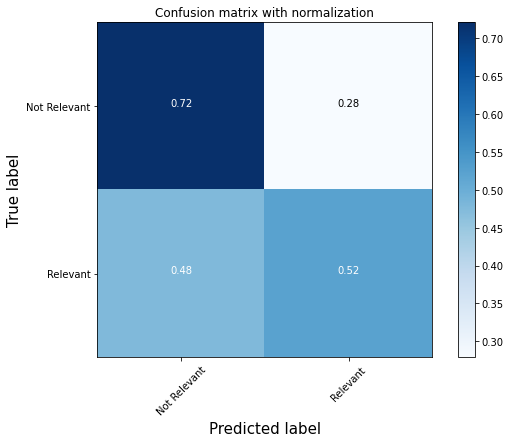

In [22]:
vect = CountVectorizer(preprocessor=clean, max_features=1000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# instantiate a SVM model
classifier = LinearSVC(class_weight="balanced")
# fit the model with training data
classifier.fit(X_train_dtm, y_train)

# Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

# calculate evaluation measures
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("AUC: ", metrics.roc_auc_score(y_test, y_pred_prob))

cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'], normalize=True, title="Confusion matrix with normalization")

When compared to logistic regression, SVMs seem to have done better with the relevant articles category, although, among this small set of experiments we did, Naive Bayes, with the smaller set of features, seems to be the best classifier for this dataset.

A real-world text classification project involves exploring multiple
options like this, starting with the simplest approach in terms of modeling, deployment, and scaling, and gradually increasing the complexity.

Our eventual goal is to build the classifier that best meets our business needs given all the other constraints.

Let’s now consider **a better feature representation**. So far in this notebook, we’ve used BoW features that based on statistical approches. 

Let’s see how we can use other feature representation techniques for text classification.